# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

#### Steps:

Load Input: We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Each pixel is 8 bits ranging from 0 (light) to 255 (dark).

Gaussian Blur: TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.
TODO: explain kernel matrix

Binary Threshold: Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.
TODO: explain OTSU's method

## 1. Import necessary libraries and setup

In [1]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
import numpy as np                 # NumPy for quick maths
from collections import Counter    # dictionary quick maths
from tem_functions import *        # import necessary functions from separate python file
import time                        # timing how long it takes to import libraries

t_pipe_init = time.perf_counter()  # begin timing pipeline

Define constants

In [2]:
threshold_1 = 55 # for 36a
threshold_2 = 35 # for 36b
threshold_3 = 45 # for 36e

print(str(nm_per_pixel), "nm per pixel")

0.8849557522123894 nm per pixel


## 2. Load input data and apply grayscale

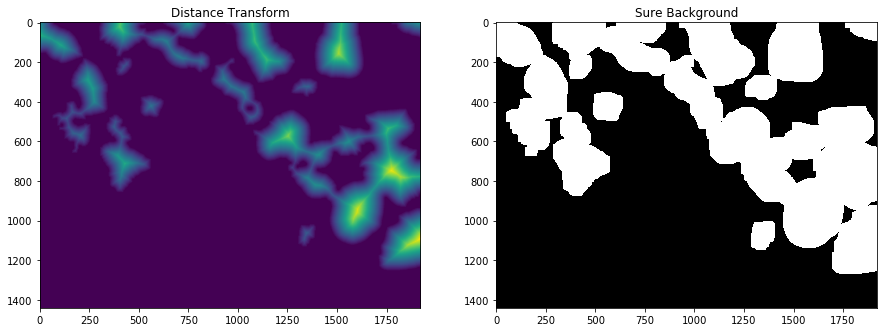

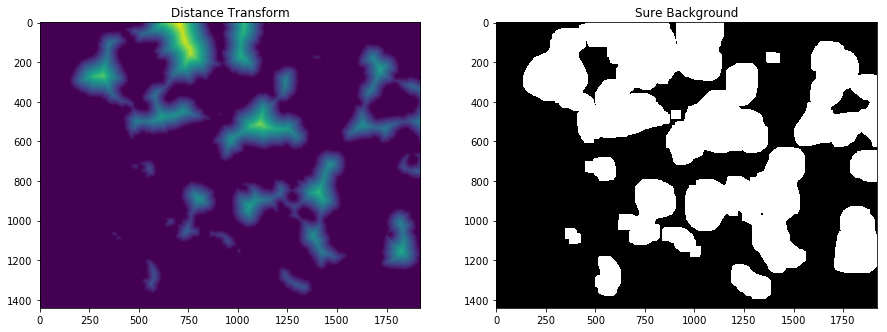

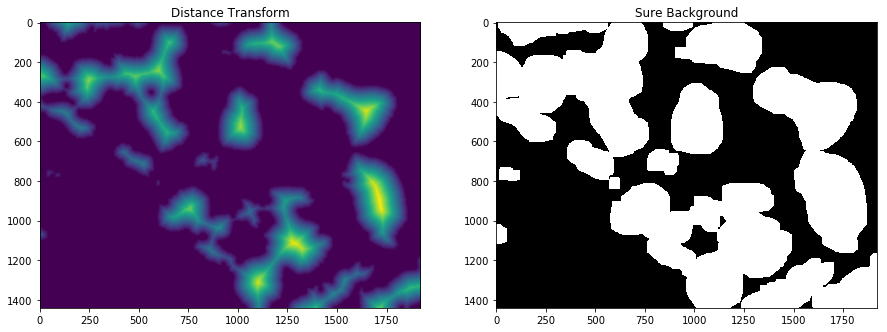

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

IMAGE_NAME_1 = "TES-36a-cropped.tif"
IMAGE_NAME_2 = "TES-36b-cropped.tif"
IMAGE_NAME_3 = "TES-36e-cropped.tif"

color_image_1, dist_transform_1, sure_bg_1 = setup(IMAGE_NAME_1, threshold_1, False)
color_image_2, dist_transform_2, sure_bg_2 = setup(IMAGE_NAME_2, threshold_2, False)
color_image_3, dist_transform_3, sure_bg_3 = setup(IMAGE_NAME_3, threshold_3, False)

## 3. Contours derived from sure background & foreground

### Contour particles 

Threshold distance transform with a higher value to get particle centers for watershed algorithm

## 4. Contours derived from Watershed algorithm

Markers pt.2 except this time they're derived from watershed instead of background - foreground

Run watershed algorithm from particle centers

First obtain contour pixels and get their colors

## 5. Find area of particles
 to see if it is worth it to run watershed on the current threshold

In [4]:
dist_transform_thresh_1 = get_watershed_threshold(dist_transform_1, sure_bg_1, color_image_1, expected_radius)
dist_transform_thresh_2 = get_watershed_threshold(dist_transform_2, sure_bg_2, color_image_2, expected_radius)
dist_transform_thresh_3 = get_watershed_threshold(dist_transform_3, sure_bg_3, color_image_3, expected_radius)
#print(dist_transform_thresh)

In [5]:
# watershed markers for finding particles (no agglomerates)
watershed_markers_1 = get_watershed_markers(dist_transform_1, dist_transform_thresh_1, sure_bg_1, color_image_1, False)
watershed_markers_2 = get_watershed_markers(dist_transform_2, dist_transform_thresh_2, sure_bg_2, color_image_2, False)
watershed_markers_3 = get_watershed_markers(dist_transform_3, dist_transform_thresh_3, sure_bg_3, color_image_3, False)

# watershed markers for finding agglomerates
agg_watershed_markers_1 = get_watershed_markers(dist_transform_1, 0.1, sure_bg_1, color_image_1, False)
agg_watershed_markers_2 = get_watershed_markers(dist_transform_2, 0.1, sure_bg_2, color_image_2, False)
agg_watershed_markers_3 = get_watershed_markers(dist_transform_3, 0.1, sure_bg_3, color_image_3, False)

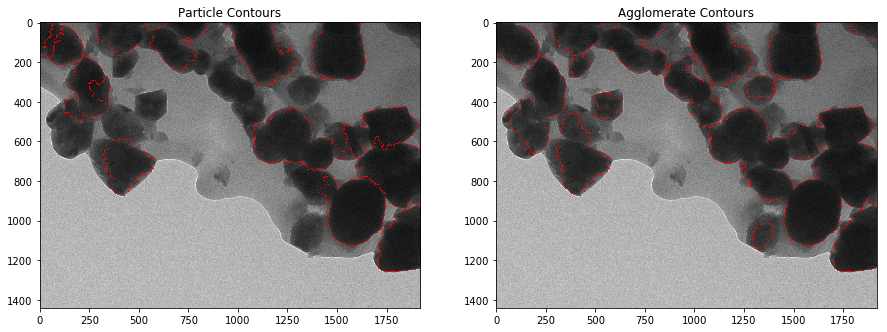

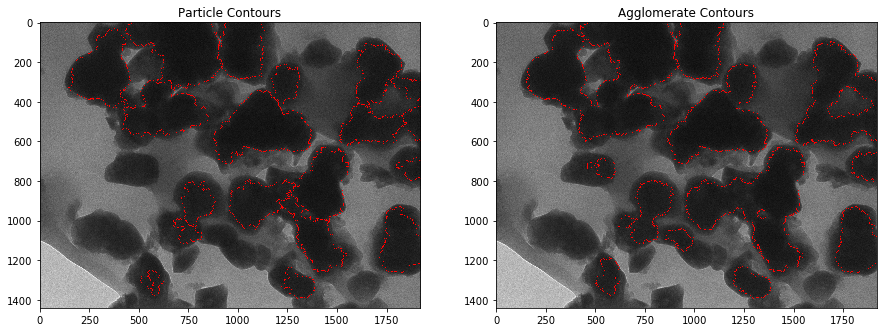

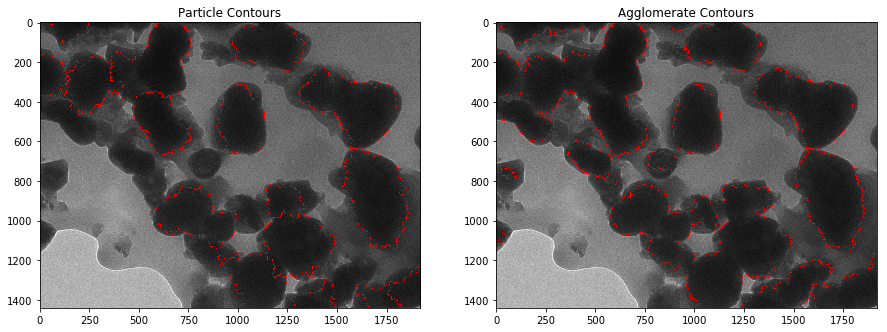

In [6]:
contour_colors_1, chords_color_copy_1 = get_contour_colors(watershed_markers_1, color_image_1)
contour_colors_2, chords_color_copy_2 = get_contour_colors(watershed_markers_2, color_image_2)
contour_colors_3, chords_color_copy_3 = get_contour_colors(watershed_markers_3, color_image_3)

agg_contour_colors_1, agg_chords_color_copy_1 = get_contour_colors(agg_watershed_markers_1, color_image_1)
agg_contour_colors_2, agg_chords_color_copy_2 = get_contour_colors(agg_watershed_markers_2, color_image_2)
agg_contour_colors_3, agg_chords_color_copy_3 = get_contour_colors(agg_watershed_markers_3, color_image_3)

display_images([chords_color_copy_1, agg_chords_color_copy_1], ["Particle Contours", "Agglomerate Contours"], [1, 1])
display_images([chords_color_copy_2, agg_chords_color_copy_2], ["Particle Contours", "Agglomerate Contours"], [1, 1])
display_images([chords_color_copy_3, agg_chords_color_copy_3], ["Particle Contours", "Agglomerate Contours"], [1, 1])

In [7]:
particles_1 = find_centerpoints(contour_colors_1)
particles_2 = find_centerpoints(contour_colors_2)
particles_3 = find_centerpoints(contour_colors_3)

agg_particles_1 = find_centerpoints(agg_contour_colors_1)
agg_particles_2 = find_centerpoints(agg_contour_colors_2)
agg_particles_3 = find_centerpoints(agg_contour_colors_3)

In [8]:
particle_areas_1 = get_areas(watershed_markers_1)
particle_areas_2 = get_areas(watershed_markers_2)
particle_areas_3 = get_areas(watershed_markers_3)

agg_areas_1 = get_areas(agg_watershed_markers_1)
agg_areas_2 = get_areas(agg_watershed_markers_2)
agg_areas_3 = get_areas(agg_watershed_markers_3)

In [9]:
# TODO: standardize way of referring to unique particle ID, here particle == color
# TODO: make v2 of function that defines agglomerate area by contour not min/max rectangle

merge_particles_1, merge_contour_colors_1 = match_images(particles_1, contour_colors_1, agg_particles_1, agg_contour_colors_1, agg_areas_1)
merge_particles_2, merge_contour_colors_2 = match_images(particles_2, contour_colors_2, agg_particles_2, agg_contour_colors_2, agg_areas_2)
merge_particles_3, merge_contour_colors_3 = match_images(particles_3, contour_colors_3, agg_particles_3, agg_contour_colors_3, agg_areas_3)
# [print(x, merge_particles[x]) for x in merge_particles.keys()]

In [10]:
long_pairs_1, merge_particles_1 = get_long_chord_lengths(merge_particles_1, merge_contour_colors_1)
long_pairs_2, merge_particles_2 = get_long_chord_lengths(merge_particles_2, merge_contour_colors_2)
long_pairs_3, merge_particles_3 = get_long_chord_lengths(merge_particles_3, merge_contour_colors_3)

# print(long_pairs)

In [11]:
short_pairs_1, merge_particles_1 = get_short_chord_lengths(merge_particles_1, merge_contour_colors_1, long_pairs_1)
short_pairs_2, merge_particles_2 = get_short_chord_lengths(merge_particles_2, merge_contour_colors_2, long_pairs_2)
short_pairs_3, merge_particles_3 = get_short_chord_lengths(merge_particles_3, merge_contour_colors_3, long_pairs_3)

print(merge_particles_1)

{2: [('x', 87.49943038378461), ('y', 106.50273871476355), ('a', 123.96726646383247), ('theta', -139.48743277847583), ('b', 80.71189440828456)], 3: [('x', 513.072440640263), ('y', 95.88169157115915), ('a', 271.15050024260574), ('theta', -157.95551896792676), ('b', 55.41582745190671)], 4: [('x', 982.3306783109031), ('y', 136.6318612002067), ('a', 190.05854150044047), ('theta', -150.27166383095857), ('b', 109.84240342749035)], 5: [('x', 1308.1000479831878), ('y', 135.67944801112725), ('a', 155.7974592363028), ('theta', -50.0694201326125), ('b', 134.8512579645084)], 6: [('x', 1634.3179951335183), ('y', 32.96653906358973), ('a', 76.34506657937679), ('theta', -149.71965971749324)], 7: [('x', 364.45380756439886), ('y', 191.7070627360352), ('a', 60.18349782626302), ('theta', -70.23283132320836)], 9: [('x', 170.2333978683352), ('y', 376.9626791181259), ('a', 222.86350439881437), ('theta', -85.33082776944293), ('b', 100.03229958437342)], 8: [('x', 873.3272361127214), ('y', 301.4242592091647), ('

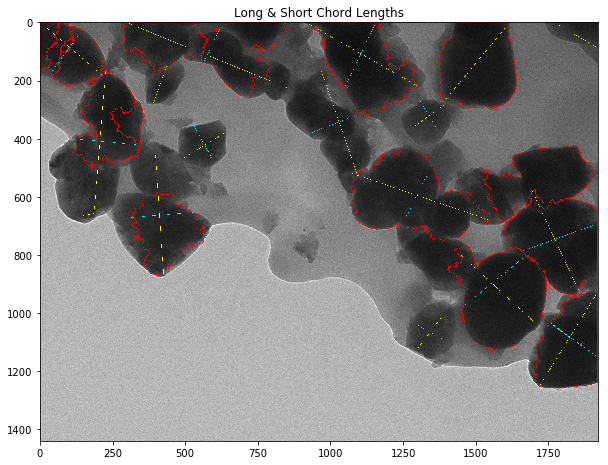

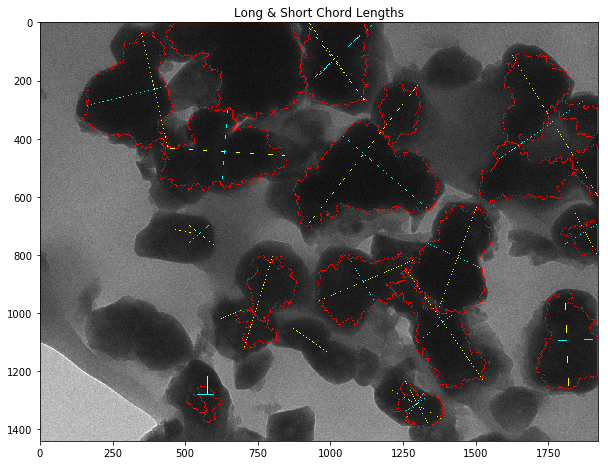

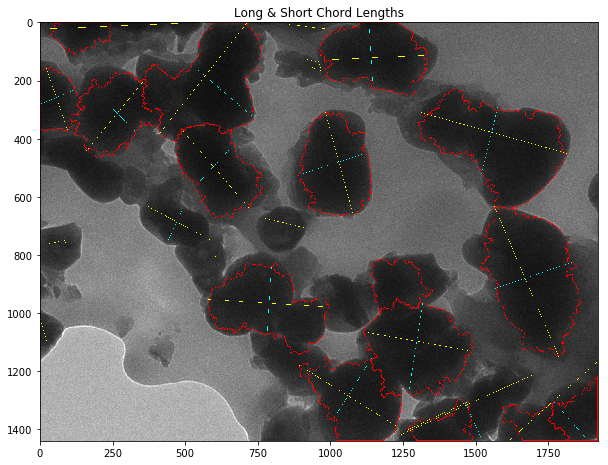

In [24]:
# draw_long_lengths(chords_color_copy, long_pairs)
# draw_short_lengths(chords_color_copy, short_pairs)
# display_images([chords_color_copy], ["Long & Short Chord Lengths"], [0])
# plt.savefig("chords_color_copy_long_short_chord_lengths.png", dpi=500)

# draw_long_lengths(chords_color_copy_1, long_pairs_1)
# draw_long_lengths(chords_color_copy_2, long_pairs_2)
# draw_long_lengths(chords_color_copy_3, long_pairs_3)

# draw_short_lengths(chords_color_copy_1, short_pairs_1)
# draw_short_lengths(chords_color_copy_2, short_pairs_2)
# draw_short_lengths(chords_color_copy_3, short_pairs_3)

# draw_long_lengths(agg_chords_color_copy, long_pairs)
# draw_short_lengths(agg_chords_color_copy, short_pairs)
# display_images([agg_chords_color_copy], ["Agg Long & Short Chord Lengths"], [0])
# plt.savefig("agg_chords_color_copy_long_short_chord_lengths.png", dpi=500)

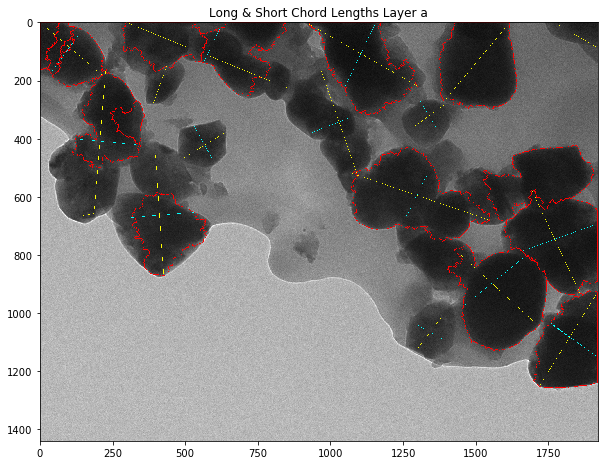

In [28]:
# display_images([chords_color_copy_1], ["Long & Short Chord Lengths Layer a"], [0])
# display_images([chords_color_copy_2], ["Long & Short Chord Lengths Layer b"], [0])
# display_images([chords_color_copy_3], ["Long & Short Chord Lengths Layer e"], [0])

# plt.savefig("long_short_chord_lengths_a.png", dpi=500)

In [13]:
def get_c(particles):
    for particle in particles:
        particle_data = particles[particle]
        if len(particle_data) == 5:
            # c = a + b / 2
            c_radius = (particle_data[2][1] + particle_data[4][1]) / 2
            particles[particle] += [("c", c_radius)]
    return particles

In [14]:
def set_max_c(particles):
    max_c = 0
    for particle in particles:
        particle_data = particles[particle]
        if len(particle_data) == 5:
            # c = a + b / 2
            c_radius = (particle_data[2][1] + particle_data[4][1]) / 2
            if c_radius > max_c:
                max_c = c_radius
    for particle in particles:
        particle_data = particles[particle]
        if len(particle_data) == 5:
            particles[particle] += [("c", max_c)]
    return particles

In [15]:
merge_particles_1 = get_c(merge_particles_1)
merge_particles_2 = get_c(merge_particles_2)
merge_particles_3 = get_c(merge_particles_3)

print(merge_particles_1)

{2: [('x', 87.49943038378461), ('y', 106.50273871476355), ('a', 123.96726646383247), ('theta', -139.48743277847583), ('b', 80.71189440828456), ('c', 102.33958043605853)], 3: [('x', 513.072440640263), ('y', 95.88169157115915), ('a', 271.15050024260574), ('theta', -157.95551896792676), ('b', 55.41582745190671), ('c', 163.28316384725622)], 4: [('x', 982.3306783109031), ('y', 136.6318612002067), ('a', 190.05854150044047), ('theta', -150.27166383095857), ('b', 109.84240342749035), ('c', 149.9504724639654)], 5: [('x', 1308.1000479831878), ('y', 135.67944801112725), ('a', 155.7974592363028), ('theta', -50.0694201326125), ('b', 134.8512579645084), ('c', 145.32435860040562)], 6: [('x', 1634.3179951335183), ('y', 32.96653906358973), ('a', 76.34506657937679), ('theta', -149.71965971749324)], 7: [('x', 364.45380756439886), ('y', 191.7070627360352), ('a', 60.18349782626302), ('theta', -70.23283132320836)], 9: [('x', 170.2333978683352), ('y', 376.9626791181259), ('a', 222.86350439881437), ('theta', 

In [16]:
def get_layer_info(particles):
    max_x = 0
    min_x = 10000
    max_y = 0
    min_y = 10000
    max_c = 0
    layer_volume = 0
    
    for particle in particles:
        particle_data = particles[particle]
        if len(particle_data) == 6:
            x = particle_data[0][1]
            y = particle_data[1][1]
            a = particle_data[2][1]
            b = particle_data[4][1]
            c = particle_data[5][1]
            layer_volume += (4/3)*np.pi*a*b*c
            if (x - a) < min_x:
                min_x = x-a
            if (x + a) > max_x:
                max_x = x+a
            if (y - a) < min_y:
                min_y = y-a
            if (y + a) > max_y:
                max_y = y+a
            if c > max_c:
                max_c = c
    
    x_length = max_x - min_x
    y_length = max_y - min_y
    
    volume_fraction = layer_volume/(x_length*y_length*max_c*2)
    
    return [x_length, y_length, min_x, min_y, max_c, layer_volume, volume_fraction]

In [17]:
info_1 = get_layer_info(merge_particles_1)
info_2 = get_layer_info(merge_particles_2)
info_3 = get_layer_info(merge_particles_3)

print(info_1)
print(info_2)
print(info_3)

[1817.9594305919986, 1310.7750080872388, -52.63010653047917, -175.2688086714466, 163.28316384725622, 132812858.84470013, 0.17066968345065064]
[1680.4466348988663, 1274.7079944748516, 96.22308551370921, -21.39152038452437, 223.98502108716747, 164982727.7758042, 0.17193095410491413]
[1783.8463743152972, 1454.548913701378, -42.71985570910222, -60.77415674573042, 187.096564123485, 151905426.06736958, 0.1564558113363051]


In [18]:
def combine_layers(particle_layers, layer_infos, filename):
    with open(filename, "w") as output_file:
        total_height = 1
        total_volume = 0
        layer_heights = []
        x_length_prism = 0
        y_length_prism = 0
        x_position_prism = 100000
        y_position_prism = 100000
        for info in layer_infos:
            total_height += ((info[4]*2) + 1)
            layer_heights += [info[4]*2]
            total_volume += info[5]
            if info[0] > x_length_prism:
                x_length_prism = info[0]
            if info[1] > y_length_prism:
                y_length_prism = info[1]
            if info[2] < x_position_prism:
                x_position_prism = info[2]
            if info[3] < y_position_prism:
                y_position_prism = info[3]
        #thickness = total_height / 100
        volume_fraction = total_volume/(x_length_prism*y_length_prism*total_height)

        particleID = 1
        layer_counter = 0
        height_adjustment = 1
        for layer in particle_layers:
            current_height = height_adjustment + (layer_heights[layer_counter]/2)
            for particle in layer:
                particle_data = layer[particle]
                if len(particle_data) == 6:
                    output_file.writelines(particle_data[2][0] + str(particleID) + " " + str(particle_data[2][1]) + "[nm]" + "\n")       # a
                    output_file.writelines(particle_data[4][0] + str(particleID) + " " + str(particle_data[4][1]) + "[nm]" + "\n")       # b
                    output_file.writelines(particle_data[5][0] + str(particleID) + " " + str(particle_data[5][1]) + "[nm]" + "\n")       # c
                    output_file.writelines(particle_data[0][0] + str(particleID) + " " + str(particle_data[0][1]) + "[nm]" + "\n")       # x
                    output_file.writelines(particle_data[1][0] + str(particleID) + " " + str(particle_data[1][1]) + "[nm]" + "\n")       # y
                    output_file.writelines("z" + str(particleID) + " " + str(current_height) + "[nm]" + "\n")                            # z
                    output_file.writelines(particle_data[3][0] + str(particleID) + " " + str(particle_data[3][1]) + "[degrees]" + "\n")  # theta
                    particleID += 1

            height_adjustment += (layer_heights[layer_counter] + 1)
            layer_counter += 1

        output_file.writelines("*****************\n")
        output_file.writelines("total_particles " + str(particleID-1) + "\n")                    # number of particles
        output_file.writelines("total_volume_ellipsoids " + str(total_volume) + "[nm^3]" + "\n") # total volume
        output_file.writelines("x_length_prism " + str(x_length_prism) + "[nm]" + "\n")          # x length prism
        output_file.writelines("y_length_prism " + str(y_length_prism) + "[nm]" + "\n")          # y length prism
        output_file.writelines("z_length_prism " + str(total_height) + "[nm]" + "\n")            # z length prism
        output_file.writelines("x_position_prism " + str(x_position_prism) + "[nm]" + "\n")      # x position prism
        output_file.writelines("y_position_prism " + str(y_position_prism) + "[nm]" + "\n")      # x position prism
        output_file.writelines("volume_fraction " + str(volume_fraction))                        # volume fraction

        # close output file
        output_file.close()           
                
                

In [19]:
# combine_layers([merge_particles_1,merge_particles_2,merge_particles_3], [info_1, info_2, info_3], "max_c_abe.txt")
# combine_layers([merge_particles_1,merge_particles_3,merge_particles_2], [info_1, info_3, info_2], "max_c_aeb.txt")
# combine_layers([merge_particles_2,merge_particles_1,merge_particles_3], [info_2, info_1, info_3], "max_c_bae.txt")
# combine_layers([merge_particles_2,merge_particles_3,merge_particles_1], [info_2, info_3, info_1], "max_c_bea.txt")
# combine_layers([merge_particles_3,merge_particles_1,merge_particles_2], [info_3, info_1, info_2], "max_c_eab.txt")
# combine_layers([merge_particles_3,merge_particles_2,merge_particles_1], [info_3, info_2, info_1], "max_c_eba.txt")



In [20]:
t_pipe_final = time.perf_counter()

print("time to run pipeline:", str(t_pipe_final - t_pipe_init), "seconds")

time to run pipeline: 750.4922460180023 seconds


In [21]:
print(merge_particles_3)

{2: [('x', 235.94825467059982), ('y', 33.24473533267781), ('a', 239.5783783187033), ('theta', -2.3286747019544336)], 20: [('x', 1307.4782824416052), ('y', 1170.393974259721), ('a', 223.38078269592663), ('theta', -24.33124191693506), ('b', 64.1577662314756), ('c', 143.76927446370112)], 21: [('x', 474.1197588897193), ('y', 191.32261421656622), ('a', 215.46809899325092), ('theta', -51.670952674253876), ('b', 125.21498467761052), ('c', 170.34154183543072)], 22: [('x', 59.70779946183811), ('y', 240.06974733590437), ('a', 102.42765517094033), ('theta', -108.90457584261165), ('b', 56.70626316318866), ('c', 79.5669591670645)], 23: [('x', 213.28322448506398), ('y', 277.467248908297), ('a', 140.84425969793108), ('theta', -50.60927444644581), ('b', 94.80701594160583), ('c', 117.82563781976845)], 24: [('x', 530.2187199984792), ('y', 448.37979905516005), ('a', 157.51466622497483), ('theta', -130.6711249328096), ('b', 80.15813722723544), ('c', 118.83640172610514)], 3: [('x', 808.1975973665085), ('y'

In [22]:
combine_layers([merge_particles_2,merge_particles_3], [info_2, info_3], "two_layer_be.txt")

In [23]:
combine_layers([merge_particles_1], [info_1], "layer_a.txt")
combine_layers([merge_particles_2], [info_2], "layer_b.txt")
combine_layers([merge_particles_3], [info_3], "layer_e.txt")
